In [1]:
import numpy as np
from qspectra import *
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
H_electronic = np.array([[11500, 66], [66, 11650]])
n_vibrational_levels = np.array([2, 2])
vib_energies = np.array([200, 200])
elec_vib_couplings = -32 * np.eye(2)
bath = DebyeBath(CM_K * 77, 1.5 * 35, 106)
dipoles = [[1,0,0], [0,1,0]]

dimer_ham = VibronicHamiltonian(
    ElectronicHamiltonian(H_electronic, dipoles=dipoles, bath=bath),
    n_vibrational_levels, vib_energies, elec_vib_couplings)
dimer = RedfieldModel(dimer_ham, hilbert_subspace='gef', unit_convert=CM_FS,
                      discard_imag_corr=True)

## Excited state dynamics

In [3]:
%%time 
t, rho = simulate_dynamics(dimer, unit_vec(0, (2 * 2 ** 2) ** 2), 1000)

CPU times: user 97.9 ms, sys: 9.39 ms, total: 107 ms
Wall time: 188 ms


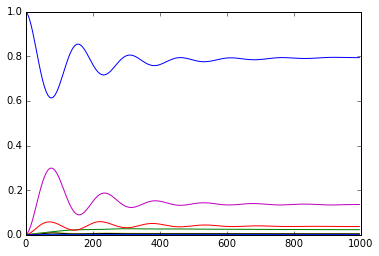

In [4]:
plt.plot(t, np.einsum('tii->ti', rho.reshape(-1, 8, 8)).real);

## Absorption spectra

In [5]:
%%time
f, X = absorption_spectra(dimer, 10000)

CPU times: user 202 ms, sys: 18.6 ms, total: 220 ms
Wall time: 445 ms


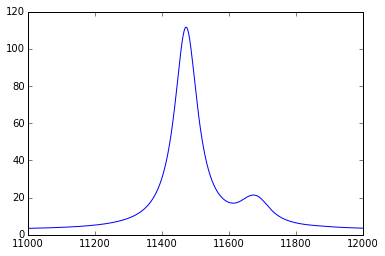

In [6]:
plt.plot(f, X)
plt.xlim(11000, 12000);

## Monomer absorption spectra (for reference)

In [7]:
monomer_ham = VibronicHamiltonian(
    ElectronicHamiltonian(H_electronic[:1, :1], dipoles=dipoles[:1], bath=bath),
    n_vibrational_levels[:1], vib_energies[:1], elec_vib_couplings[:1, :1])
monomer = RedfieldModel(monomer_ham, hilbert_subspace='ge', unit_convert=CM_FS)

In [8]:
%%time
f, X = absorption_spectra(monomer, 10000)

CPU times: user 87 ms, sys: 3.82 ms, total: 90.8 ms
Wall time: 191 ms


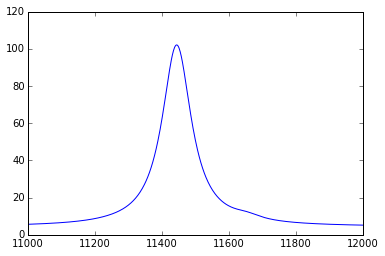

In [9]:
plt.plot(f, X)
plt.xlim(11000, 12000);

## 2D spectra

In [ ]:
%%time
(t1, t2, t3), X = third_order_response(dimer, coherence_time_max=1000,
                                       population_times=np.linspace(0, 1000, num=100),
                                       geometry='-++', polarization='xxxx',
                                       include_signal='GSB', exact_isotropic_average=True)

In [11]:
%%time
f1, X_ftt = fourier_transform(t1, X, axis=0, rw_freq=dimer.rw_freq, sign=-1, unit_convert=CM_FS)
f3, X_ftf = fourier_transform(t3, X_ftt, axis=2, rw_freq=dimer.rw_freq, unit_convert=CM_FS)

CPU times: user 14.6 s, sys: 1.03 s, total: 15.6 s
Wall time: 15.7 s


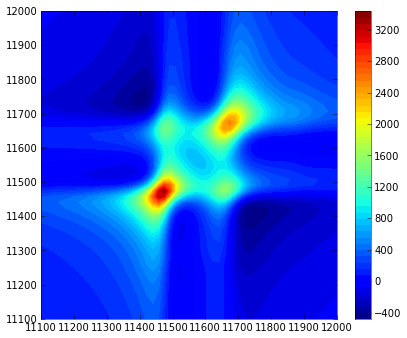

In [12]:
plt.figure(figsize=(6,5))
plt.contourf(f3, f1, X_ftf[:,0,:].real.T, 50)
plt.xlim(11100, 12000)
plt.ylim(11100, 12000)
plt.colorbar();

In [13]:
alpha, beta = np.argmin(np.abs(f1 - np.array([11530, 11730]).reshape(-1,1)), 1)

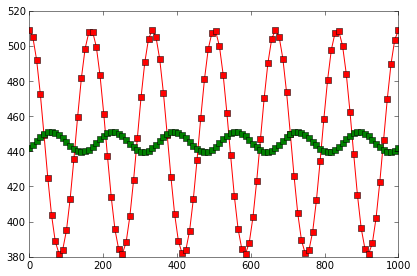

In [14]:
plt.plot(t2, X_ftf[beta, :, alpha].real, '-sr')
plt.plot(t2, X_ftf[alpha, :, beta].real, '-sg');